# Dynamical System Forecasting with an Echo State Network

In this notebook we will train an Echo State Netwoek on Mackey-Glass data.


In [1]:
import sys
from pathlib import Path

import numpy as np
import jax
import jax.random as jr
import jax.numpy as jnp
import equinox as eqx
import matplotlib.pyplot as plt
from rnn_jax.cells.vanilla import ElmanRNNCell
from rnn_jax.layers.reservoir import ReservoirComputer, init_reservoir_esn

Now. let's generate a dynamical system. We'll predict a dynamucal system called Mackey-Glass. For the parameters in the code, this system has mildly chaotic dynamics, which make it a suitable benchmark for recurrent models' forecasting capabilities

In [2]:
def mackey_glass(length, tau=17, beta=0.2, gamma=0.1, n=10, dt=1.0, x0=1.2):
    """Generate a Mackey-Glass time series using a simple Euler integrator.

    Args:
        length (int): number of output samples to produce
        tau (int): delay in steps
        beta, gamma, n: Mackey-Glass parameters
        dt (float): timestep for Euler integration (kept =1 here)
        x0 (float): initial condition for the history buffer

    Returns:
        ndarray shape (length,): generated time series
    """
    history = np.zeros(length + tau + 1, dtype=np.float64)
    history[: tau + 1] = x0
    for t in range(tau, length + tau):
        x_tau = history[t - tau]
        dx = beta * x_tau / (1.0 + x_tau**n) - gamma * history[t]
        history[t + 1] = history[t] + dt * dx
    return history[tau + 1 :]

As a metric, we use the Normalized Root Mean Squared Error (NRMSE)

In [3]:
def nrmse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    denom = np.std(y_true)
    return np.sqrt(mse) / (denom + 1e-12)

We generate the data time series. We will run the integration for 7000 steps, using the first 5000 for training, the other for testing.

In [4]:
total = 8000
train_steps = 5000
test_steps = 2000
washout = 1000
hdim = 100
seed = 0
ridge = 1e-8
save_plots = True

# generate data
series = mackey_glass(total + 1)
x_all = series[:-1].reshape(-1, 1)  # x(t)
y_all = series[1:].reshape(-1, 1)  # x(t+1)

x_train = x_all[:train_steps]
y_train = y_all[:train_steps]
x_test = x_all[train_steps : train_steps + test_steps]
y_test = y_all[train_steps : train_steps + test_steps]

print(f"train shape {x_train.shape}, test shape {x_test.shape}")

train shape (5000, 1), test shape (2000, 1)


Now, we will initialize the reservoir. Here, the important bit is the `init_reservoir_esn` function, that initializes the input, recurrent and bias parameters with the desired scaling.

In [5]:
key = jr.key(seed)
ikey, rkey, init_key = jr.split(key, 3)
cell = ElmanRNNCell(1, hdim, key=ikey)
esn = ReservoirComputer(cell, odim=1, key=rkey)  # an Echo State Network
esn = init_reservoir_esn(init_key, esn, 0.9, 1, 0.0)

We train the ESN by computing the states, dropping the first transient states and solving the normal equation to train the readout

In [6]:
# compute reservoir states for training, drop washout, and fit readout
res_train = esn.compute_reservoir(x_train)
res_train_fit = res_train[washout:]
y_train_fit = jnp.array(y_train[washout:]).squeeze()
esn = esn.fit_readout(res_train_fit, y_train_fit, ridge=ridge)

Finally, we predict the states. We use the last training state as the starting point for predicting the test states, and call directly the ESN. Doing this, we compute directly the outputs, passing also from the readout.

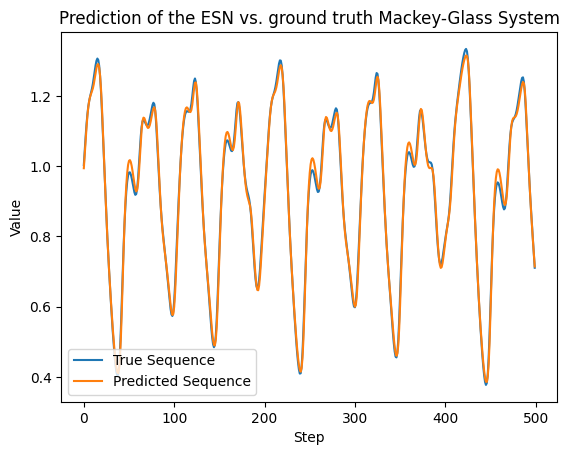

In [ ]:
# One-step-ahead (open-loop) predictions on the test set
y_pred_open = esn(x_test, last_state=(res_train[-1],))
plt.plot()
t = np.arange(500)
true = y_test[: len(t)].squeeze()
pred = np.asarray(y_pred_open[: len(t)]).squeeze()
plt.plot(t, true, label="True Sequence")
plt.plot(t, pred, label="Predicted Sequence")
plt.xlabel("Step")
plt.ylabel("Value")
plt.title("Prediction of the ESN vs. ground truth Mackey-Glass System")
plt.legend()
plt.show()

In [10]:
print("Test NRMSE: ", nrmse(y_test, y_pred_open))

Test NRMSE:  0.06106159387886412


Visually and from the NRMSE, we can see that the test states get correctly predicted by the model!